# Nregions Inference: 21-cm monopole
#### Following on from Multifrequency code and Anstey FG regions Model, we are now interested in bringing it all together to infer the 21-cm foregrounds using the Anstey model.

In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import src.forward_model as FM
import src.beam_functions as BF
import src.sky_models as SM
from src.spherical_harmonics import RealSphericalHarmonics
RS = RealSphericalHarmonics()
from nregions_inference_cm21mon import cm21_fid_pars

from chainconsumer import ChainConsumer
from emcee import EnsembleSampler

In [2]:
# Forward model the fiducial degraded GSMA.
Nfreq = 51
nuarr = np.linspace(50,100,Nfreq)
lmax = 32
nside = 16
npix = hp.nside2npix(nside)
narrow_cosbeam = lambda x: BF.beam_cos(x, theta0=0.8)
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax)
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_fid_pars)

times = np.linspace(0,24,24, endpoint=False)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_multifreq(nuarr, nside, lmax, Ntau=len(times), times=times, beam_use=narrow_cosbeam, return_mat=True)

d = mat_A@(fg_alm+cm21_alm)
dnoisy, noise_covar = SM.add_noise(temps=d, dnu=1, Ntau=npix, t_int=1e4)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


3072 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


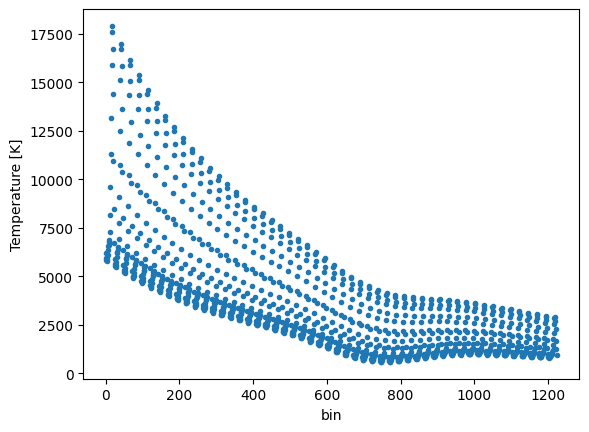

In [13]:
plt.plot(dnoisy.vector, '.')
plt.xlabel("bin")
plt.ylabel("Temperature [K]")
plt.show()

In [4]:
def showcase_inferred_cm21mon(nuarr, chain, fid_pars):
    # Showcase the 21-cm inference by sampling 1000 points from the posterior and building 1 and 2 sigma regions.
    # Sample the posterior.
    nuarr_fat = np.linspace(nuarr[0], nuarr[-1], 1000)
    point_idx = np.random.randint(len(chain_clean), size=1000)
    chain_samples = chain[point_idx]
    cm21_samples = chain_samples[:,-3:]
    
    # Evaluate the model at the posterior sample points.
    inferred_cm21 = np.array([SM.cm21_globalT(nuarr_fat, *cm21_sample) for cm21_sample in cm21_samples])
    
    # Make the 1000 lines into a 1 sigma region for the monopole.
    inferred_cm21_mean  = np.mean(inferred_cm21, axis=0)
    inferred_cm21_std   = np.std(inferred_cm21, axis=0)
    
    # Evaluate the fiducial model.
    cm21_fid = SM.cm21_globalT(nuarr_fat, *fid_pars)
    
    plt.plot(nuarr_fat, cm21_fid, linestyle='dashed', color='k')
    plt.fill_between(nuarr_fat, inferred_cm21_mean-2*inferred_cm21_std, 
        inferred_cm21_mean+2*inferred_cm21_std,
        color='C1',
        edgecolor=None,
        alpha=0.4
    )
    plt.fill_between(nuarr_fat, inferred_cm21_mean-inferred_cm21_std, 
        inferred_cm21_mean+inferred_cm21_std,
        color='C1',
        alpha=0.8
    )
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Temperature [K]')
    plt.show()

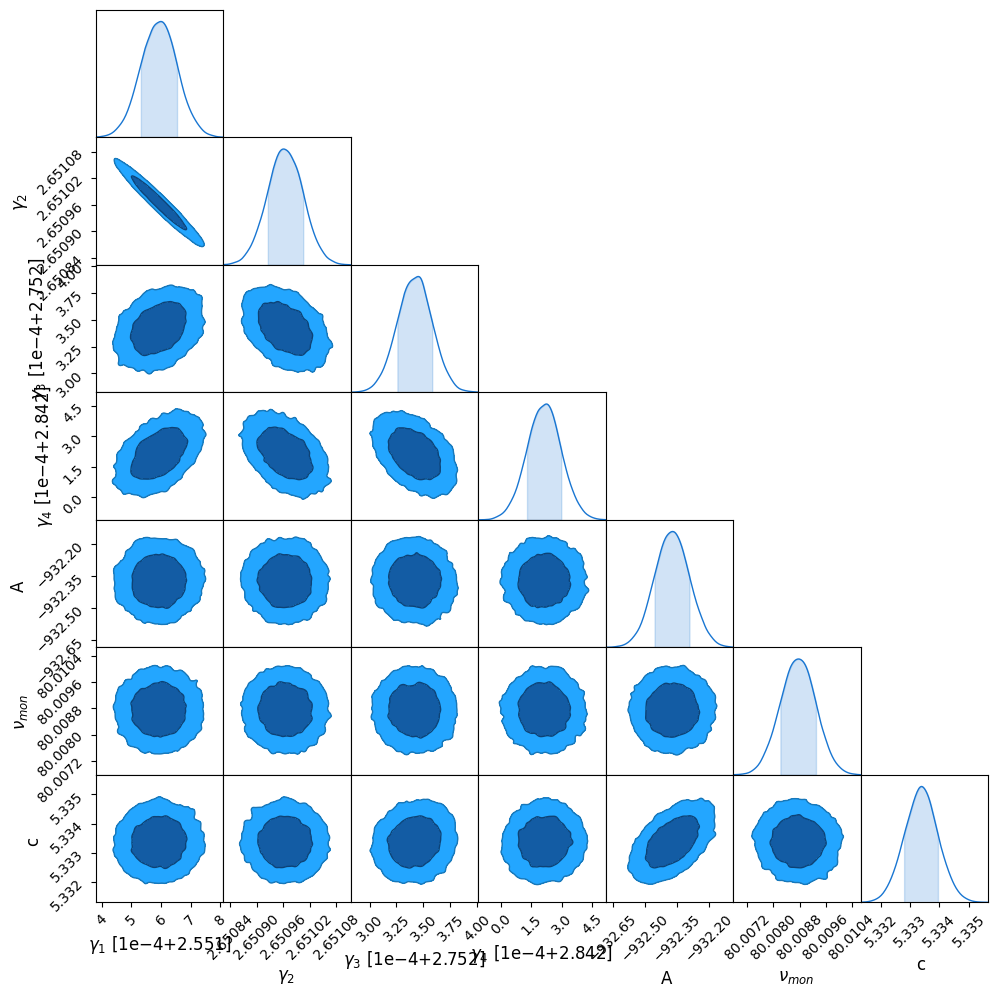

In [5]:
chain = np.load("saves/Nregs_pl_gsmalo_cm21mon/4reg_unoise_1.npy")
c=ChainConsumer()
chain = chain[5000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
chain_clean = chain_flat#np.array([elt for elt in chain_flat if elt[0]>2.6])
c.add_chain(chain_clean, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$', "A", r'$\nu_{mon}$', 'c'])
c.plotter.plot()
plt.show()

INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.00

3072 561


INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.00

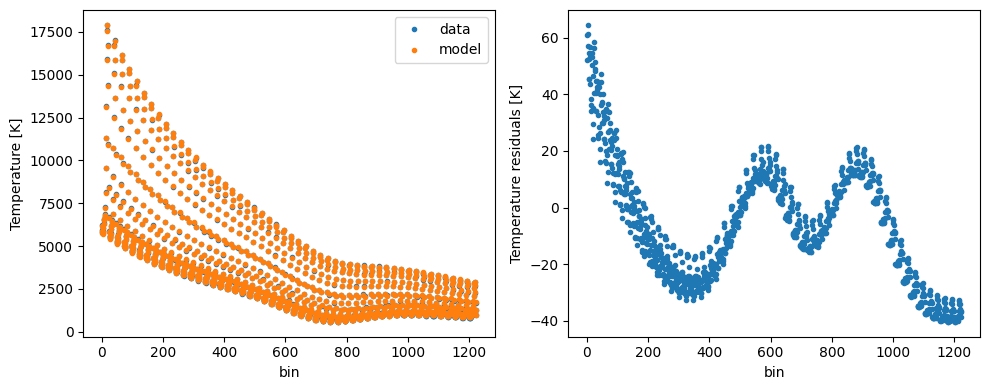

In [6]:
# Generate most-likely data.
import nregions_inference_cm21mon as NRI2
theta_mean = np.mean(chain_clean, axis=0)
analysis_dict = c.analysis.get_summary(squeeze=True)
theta_mode = [val[1] for val in analysis_dict.values()]

model = NRI2.main(Nregions=4, return_model=True)
model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()

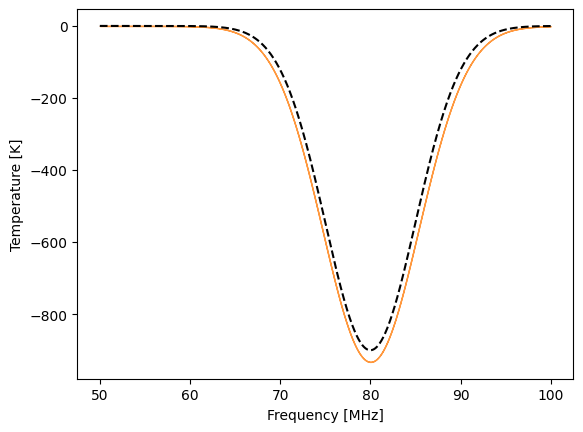

In [7]:
showcase_inferred_cm21mon(nuarr, chain_clean, cm21_fid_pars)

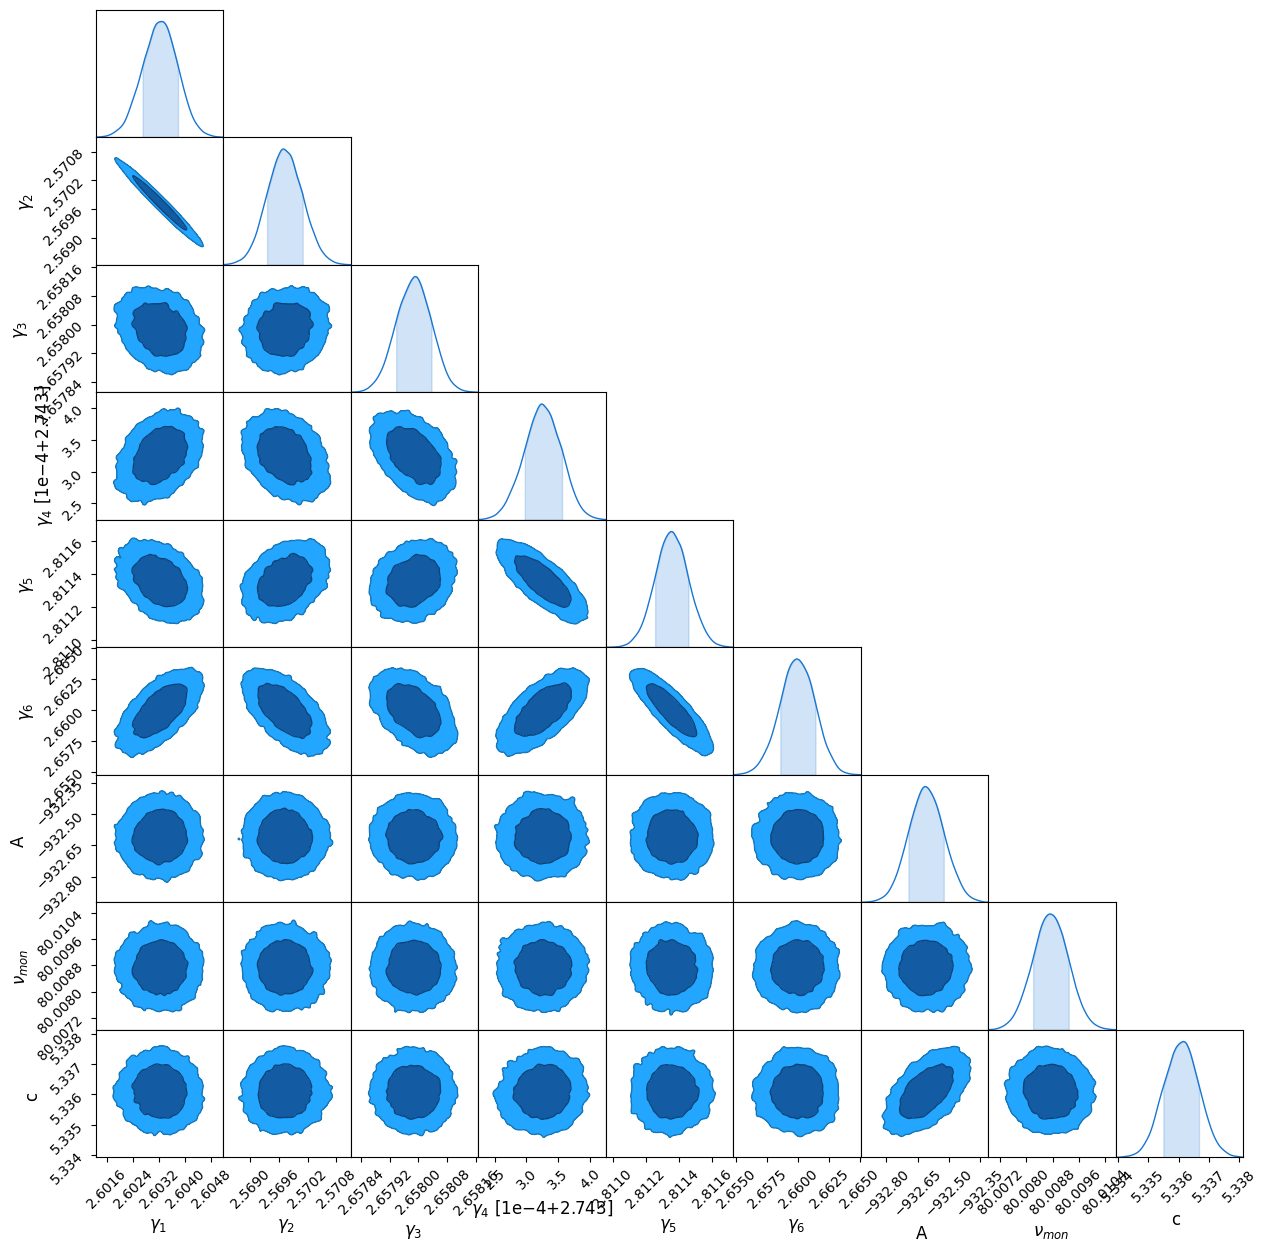

In [8]:
chain = np.load("saves/Nregs_pl_gsmalo_cm21mon/6reg_unoise_1.npy")
c=ChainConsumer()
chain = chain[5000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
chain_clean = chain_flat#np.array([elt for elt in chain_flat if elt[0]>2.6])
c.add_chain(chain_clean, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$', "A", r'$\nu_{mon}$', 'c'])
c.plotter.plot()
plt.show()

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm

3072 561


INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.00

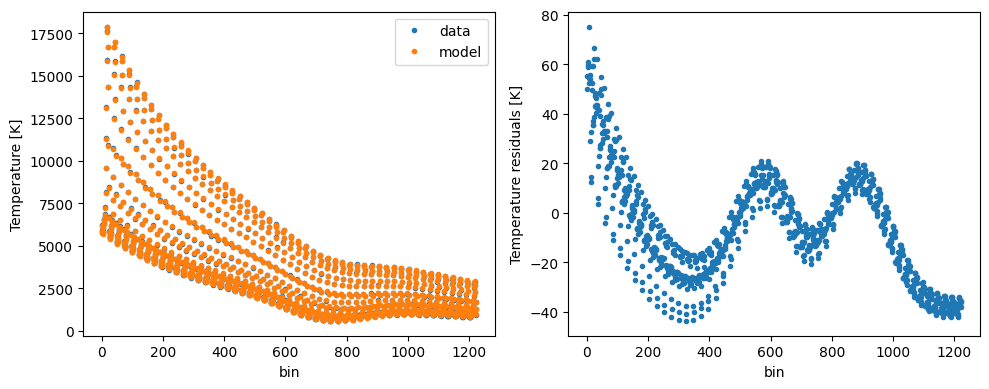

In [9]:
# Generate most-likely data.
import nregions_inference_cm21mon as NRI2
theta_mean = np.mean(chain_clean, axis=0)
analysis_dict = c.analysis.get_summary(squeeze=True)
theta_mode = [val[1] for val in analysis_dict.values()]

model = NRI2.main(Nregions=6, return_model=True)
model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()

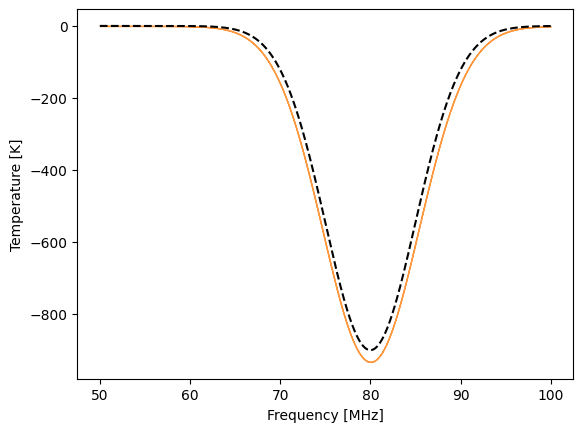

In [10]:
showcase_inferred_cm21mon(nuarr, chain_clean, cm21_fid_pars)

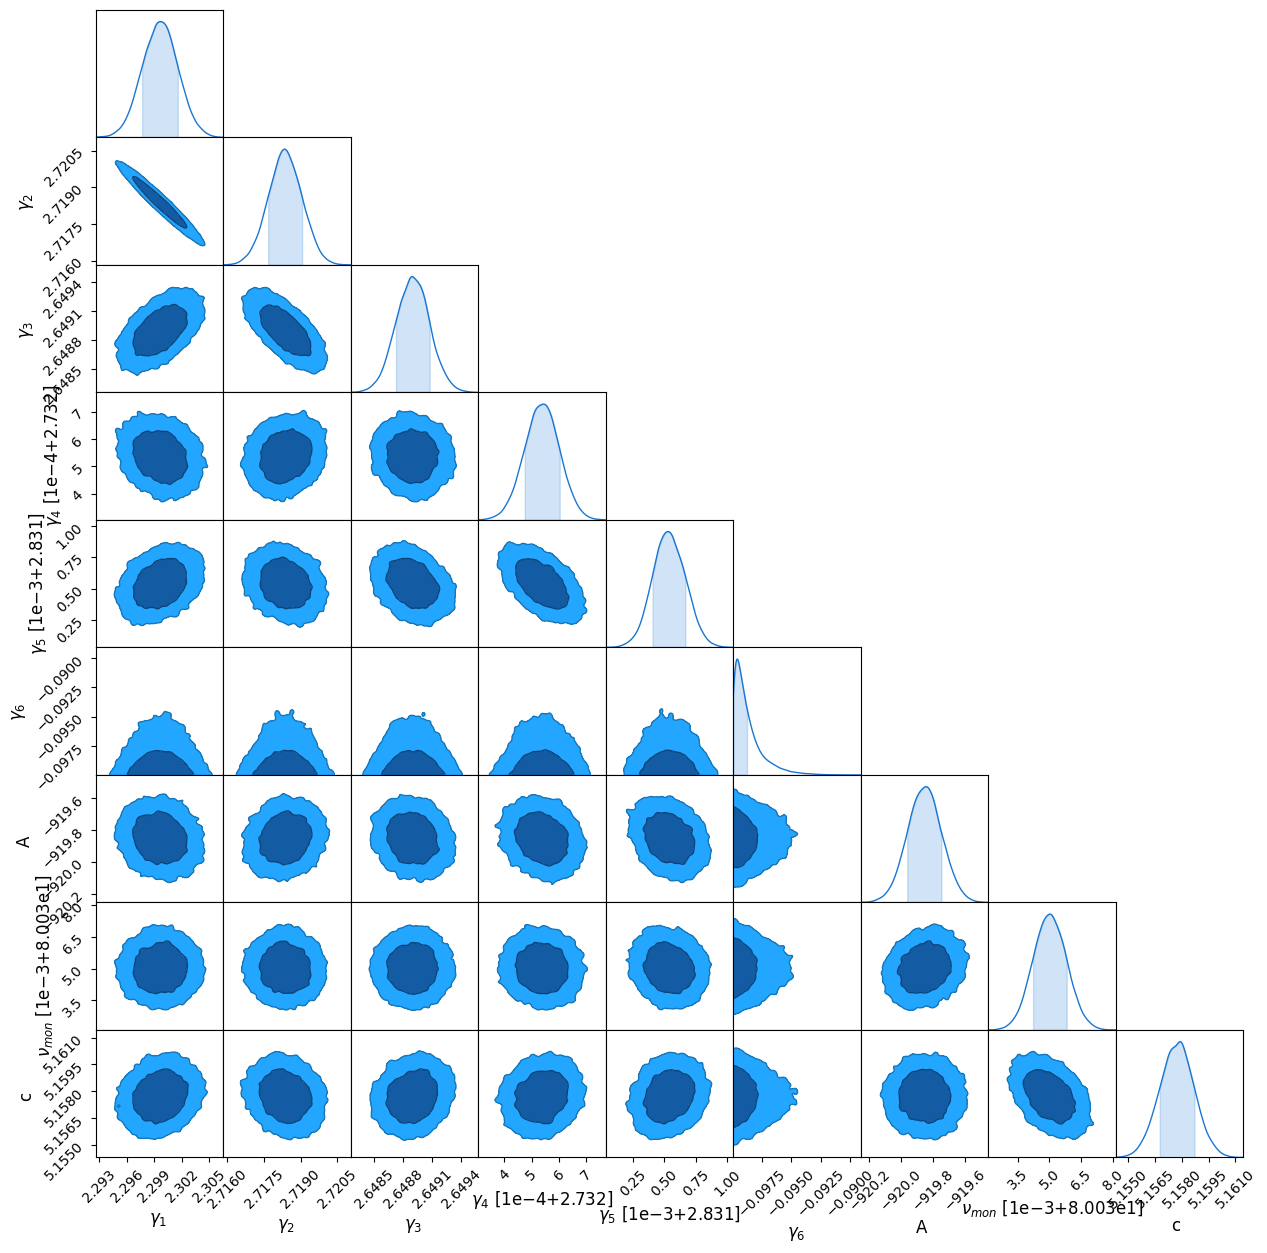

In [14]:
chain = np.load("saves/Nregs_pl_gsmalo_cm21mon/6reg_radnoise_1.npy")
c=ChainConsumer()
chain = chain[5000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
chain_clean = chain_flat#np.array([elt for elt in chain_flat if elt[0]>2.6])
c.add_chain(chain_clean, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$', "A", r'$\nu_{mon}$', 'c'])
c.plotter.plot()
plt.show()

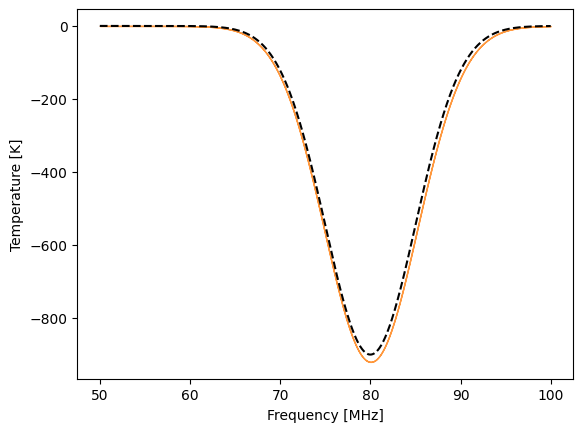

In [12]:
showcase_inferred_cm21mon(nuarr, chain_clean, cm21_fid_pars)